In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.io import loadmat
import scipy.optimize

In [2]:
ex8 = loadmat('../Git/ex8_movies.mat')
#ex8

In [3]:
#R is the ratings flag array and Y is the ratings array for 943 users and 1682 movies

R = ex8['R']
Y = ex8['Y']

In [4]:
Y.shape, R.shape

((1682, 943), (1682, 943))

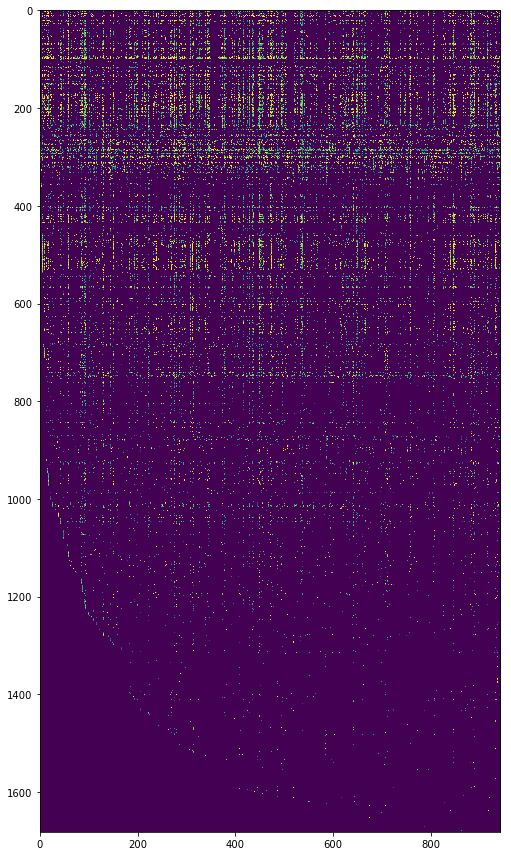

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
plt.imshow(Y)
plt.tight_layout()

In [6]:
#Loading parameters from movieParams
param = loadmat('../Git/ex8_movieParams.mat')

In [7]:
#here theta is the parameter vector for each user and X is the parameter vector for each movie
theta = param['Theta']
X = param['X']
(theta.shape, X.shape)

((943, 10), (1682, 10))

In [8]:
nu = int(param['num_users']) #total user
nm = int(param['num_movies']) #total movies
nf = int(param['num_features']) #features to be used

In [9]:
#theta vector are the parameter vector for each user and X are parameter vector for each movie

'''def cost(params, Y, R, nm=nm, nu=nu, nf=nf):
    #implement a cost function without regularization
    
    X = params[:nm*nf].reshape(nm, nf)
    theta = params[nm*nf:].reshape(nu, nf)
    J = 0.5 * np.sum(np.power((np.dot(X, theta.T) - Y), 2) * R)
    return J'''

'def cost(params, Y, R, nm=nm, nu=nu, nf=nf):\n    #implement a cost function without regularization\n    \n    X = params[:nm*nf].reshape(nm, nf)\n    theta = params[nm*nf:].reshape(nu, nf)\n    J = 0.5 * np.sum(np.power((np.dot(X, theta.T) - Y), 2) * R)\n    return J'

In [10]:
def collaborative_cost(params, Y, R, nm=nm, nu=nu, nf=nf, lambda1=0.):
    X = params[:nm*nf].reshape(nm, nf)
    theta = params[nm*nf:].reshape(nu, nf)
    
    #implement a cost function with regularization
    
    J = 0.5* np.sum(np.power((np.dot(X, theta.T) - Y), 2) * R)
    J = J + lambda1 * 0.5 * np.sum(np.power(X, 2))
    J = J + lambda1 * 0.5 * np.sum(np.power(theta, 2))
    return J

'''def collaborative_cost_prime(params, Y, R, nm=nm, nu=nu, nf=nf, lambda1=0.):
    X = params[:nm*nf].reshape(nm, nf)
    theta = params[nm*nf:].reshape(nu, nf)
    
    #calculate the regularized cost gradient
    error = (np.dot(X, theta.T) - Y) * R
    del_theta = np.dot(error.T, X) + lambda1 * theta # (943, 10)
    del_x = np.dot(error, theta) + lambda1 * X #(1682, 10)
    
    return np.concatenate((del_x.ravel(), del_theta.ravel()))'''
    

'def collaborative_cost_prime(params, Y, R, nm=nm, nu=nu, nf=nf, lambda1=0.):\n    X = params[:nm*nf].reshape(nm, nf)\n    theta = params[nm*nf:].reshape(nu, nf)\n    \n    #calculate the regularized cost gradient\n    error = (np.dot(X, theta.T) - Y) * R\n    del_theta = np.dot(error.T, X) + lambda1 * theta # (943, 10)\n    del_x = np.dot(error, theta) + lambda1 * X #(1682, 10)\n    \n    return np.concatenate((del_x.ravel(), del_theta.ravel()))'

In [11]:
#checking the cost function

users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(theta_sub)))

print(collaborative_cost(params, Y_sub, R_sub, nm = movies, nu=users, nf=features))
print(collaborative_cost(params, Y_sub, R_sub, nm = movies, nu=users, nf=features, lambda1=1.5))

22.2246037257
31.3440562443


# We'll start with adding a new user with some predictions after reading the movie_ids file

In [12]:
#read the movies file and store it to a dictionary movies and return it

def read_movies():
    movies = {}
    with open('../Git/movie_ids.txt') as f:
        for i, line in enumerate(f):
            movie = re.sub(r'^\d+', '', line)
            movie = re.sub(r'$\\n', '', movie)
            movie = movie.strip()
            movies[i] = movie
            
    return movies

movies = read_movies()

In [13]:


#initialize a ratings array
#Let's rate first 10 movies

my_ratings = np.zeros((1682,1))

my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5


In [14]:
'''Now we'll add these ratings for a new user to ratings file Y 
and ratings flag file F, chaging their dimension to (1682, 944)'''

Y = np.append(Y, my_ratings, axis=1)
R = np.append(R, (my_ratings!=0).astype(int), axis=1) #ratings!=0 returns boolean, convert it to int and append it

In [15]:
'''We'll now define a mean normalization function which will deduct mean of all ratings by the user from the matrix Y,
this assumes mean ratings for the movie a new user, without it the cost function forces the parameters to be zero 
and the ratings as well'''

Y_mean = np.sum(Y, axis=1)/np.sum(R, axis=1)
Y_mean = Y_mean.reshape(Y_mean.shape[0], 1) #reshaping for broadcasting
Y_mn = Y - Y_mean

# Now we're ready to make predictions with randomly initialized movie and user parameters

In [16]:
def collaborative_cost_prime(params, Y, R, nm=nm, nu=nu, nf=nf, lambda1=0.):
    X = params[:nm*nf].reshape(nm, nf)
    theta = params[nm*nf:].reshape(nu, nf)
    
    #calculate the regularized cost gradient
    error = (np.dot(X, theta.T) - Y) * R
    del_theta = np.dot(error.T, X) + lambda1 * theta # (943, 10)
    del_x = np.dot(error, theta) + lambda1 * X #(1682, 10)
    
    return np.concatenate((del_x.ravel(), del_theta.ravel()))

In [17]:
#no of users are now nu+1 as we had added a new user with some ratings, so we'll get the dimensions again

nu = Y.shape[1]
nm = Y.shape[0]
nf = 10

X_init = np.random.rand(nm, nf)
theta_init = np.random.rand(nu, nf)

params = np.concatenate((X_init.ravel(), theta_init.ravel()))
lambda1 = 10 #as used in the MATLAB code

'''result = scipy.optimize.fmin_cg(collaborative_cost, x0=params, fprime=collaborative_cost_prime, \
                               args=(Y_mn, R, nu, nm, nf, lambda1), \
                                maxiter=50,disp=True,full_output=True)'''

result = scipy.optimize.minimize(fun=collaborative_cost, x0=params, args=(Y_mn, R, nm, nu, nf, lambda1),\
                                 method='CG', jac=collaborative_cost_prime, options={'maxiter': 100})



In [18]:
result

     fun: 38956.383503970545
     jac: array([ 0.06254267,  0.02829911,  0.18782486, ...,  0.0022939 ,
       -0.00074662,  0.00381924])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 155
     nit: 100
    njev: 155
  status: 1
 success: False
       x: array([-0.00747977,  0.69933174,  0.39502084, ...,  0.12906443,
       -0.06081186,  0.05117829])

In [19]:

%time result1 = scipy.optimize.fmin_cg(collaborative_cost, x0=params, fprime=collaborative_cost_prime, \
                               args=(Y_mn, R, nm, nu, nf, lambda1), \
                                maxiter=50,disp=True,full_output=True)
result1

         Current function value: 38993.851773
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77
CPU times: user 15.4 s, sys: 1.39 s, total: 16.8 s
Wall time: 8.5 s


(array([-0.00601896,  0.66567611,  0.45731883, ...,  0.08237586,
         0.0344494 ,  0.03441554]), 38993.851772753624, 77, 77, 1)

# Pull the parameters for the minimized function and store them into learned parameters

In [20]:
learned_X = result['x'][:nm*nf].reshape(nm, nf) #(1682, 10)
learned_theta = result['x'][nm*nf:].reshape(nu, nf) #(944, 10), I added me as the last user

#Now finally for the recommendation for the new user

predictions = learned_X.dot(learned_theta.T)

'''These predictions were made by mean normalized rating matrix (Y), so to undo it add the mean to the 
last column of user-movie matrix'''

user_predictions = predictions[:, -1].reshape(predictions.shape[0], 1) + Y_mean

In [21]:
'''We now have the ratings for all the movies for the last user, 
first pull out sorted indexes and arrange them in descending'''

#get the index sorted by values at the index
pred_idxs_sorted = np.argsort(user_predictions, axis=0)

#reverse the sorted indexes to arrange in descending order
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

In [22]:
#Print out the movie recommendations

for i in range(10):
    print("You would like %s movie with %0.1f rating" %(movies[int(pred_idxs_sorted[i])], float(user_predictions[pred_idxs_sorted[i]])))

You would like Aiqing wansui (1994) movie with 5.0 rating
You would like Someone Else's America (1995) movie with 5.0 rating
You would like Saint of Fort Washington, The (1993) movie with 5.0 rating
You would like Star Kid (1997) movie with 5.0 rating
You would like Great Day in Harlem, A (1994) movie with 5.0 rating
You would like They Made Me a Criminal (1939) movie with 5.0 rating
You would like Santa with Muscles (1996) movie with 5.0 rating
You would like Marlene Dietrich: Shadow and Light (1996) movie with 5.0 rating
You would like Entertaining Angels: The Dorothy Day Story (1996) movie with 5.0 rating
You would like Prefontaine (1997) movie with 5.0 rating
